## Import

In [ ]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torchsummary import summary
from PIL import Image
import os
import re
import nibabel as nib

## Data Load

In [ ]:
zip_path = sorted(glob('/content/drive/Shareddrives/캡스톤 디자인1/dataset/multiclass_clahe_512/*'))

In [ ]:
zip_path[0].split('/')[-1].split('.')[0]

'images_01'

In [ ]:
import zipfile
for path in zip_path:
  zip_file = zipfile.ZipFile(path)
  zip_file.extractall('/content/datasets/'+path.split('/')[-1].split('.')[0])
  zip_file.close()

In [ ]:
PATH = '/content/datasets/'
from glob import glob
file_data = glob(PATH+'*')

In [ ]:
image_path =list()
for path in file_data:
  infile_image_path = glob(path+'/*.png')
  image_path+=infile_image_path
image_path = sorted(image_path)

In [ ]:
len(image_path)

55870

## Data Load

In [ ]:
import pandas as pd
df= pd.read_csv('/content/drive/Shareddrives/캡스톤 디자인1/processed_data_entry.csv')

In [ ]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,"Cardiomegaly,Emphysema",1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,"Cardiomegaly,Effusion",2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
76661,00030801_001.png,"Mass,Pneumonia",1,30801,38,M,PA,2048,2500,0.168,0.168
76662,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
76663,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
76664,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [ ]:
df=df.iloc[:,:2]

In [ ]:
df[df['Finding Labels']!='No Finding']

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,"Cardiomegaly,Emphysema"
2,00000001_002.png,"Cardiomegaly,Effusion"
4,00000003_001.png,Hernia
5,00000003_002.png,Hernia
...,...,...
76645,00030786_006.png,Consolidation
76648,00030789_000.png,Infiltration
76652,00030793_000.png,"Mass,Nodule"
76654,00030795_000.png,Pleural_Thickening


In [ ]:
labeling_df = pd.read_csv('/content/drive/Shareddrives/캡스톤 디자인1/multi_class_path+label_nofinding_drop.csv')

In [ ]:
labeling_df

,Image Index,Finding Labels
0,/content/datasets/images_01/00000001_000.png,Cardiomegaly
1,/content/datasets/images_01/00000003_000.png,Hernia
2,/content/datasets/images_01/00000003_001.png,Hernia
3,/content/datasets/images_01/00000003_002.png,Hernia
4,/content/datasets/images_01/00000003_004.png,Hernia
...,...,...
30958,/content/datasets/images_12/00030780_000.png,Atelectasis
30959,/content/datasets/images_12/00030786_000.png,Effusion
30960,/content/datasets/images_12/00030786_006.png,Consolidation
30961,/content/datasets/images_12/00030789_000.png,Infiltration


In [ ]:
value_series=labeling_df['Finding Labels'].value_counts()
value_dict = dict()
for i in range(len(value_series)):
    index = labeling_df['Finding Labels'].value_counts().index[i].split(',')
    if len(index) < 2: # dictionary data를 만들기 위해서 일단 단일의 질병만 가지고 있는 사람들을 dicstionary형태로 만듬.
        value_dict[index[0]] =  labeling_df['Finding Labels'].value_counts()[i]
label_list=sorted(list(value_dict.keys()))

In [ ]:
label_list

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [ ]:
class2idx = {cls:idx for idx, cls in enumerate(label_list)}
class2idx

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'Nodule': 10,
 'Pleural_Thickening': 11,
 'Pneumonia': 12,
 'Pneumothorax': 13}

In [ ]:
class2idx[df[df['Image Index']== image_path[0].split('/')[-1]]['Finding Labels'].values[0]]

1

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(labeling_df,test_size = 0.2,random_state = 42,stratify = labeling_df['Finding Labels'])
train_path = list(train_df['Image Index'].values)
val_path = list(val_df['Image Index'].values)

In [ ]:
class Train_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = np.array(Image.open(path))
        img = img/255
        img = img[:,:,np.newaxis]    
        label = class2idx[df[df['Image Index']== path.split('/')[-1]]['Finding Labels'].values[0]]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
class val_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = np.array(Image.open(path))
        img = img/255
        img = img[:,:,np.newaxis]    
        label = class2idx[df[df['Image Index']== path.split('/')[-1]]['Finding Labels'].values[0]]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image, label

In [ ]:
class2idx[labeling_df[labeling_df['Image Index']== image_path[0]]['Finding Labels'].values[0]]

1

In [ ]:
#!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 7.3 MB/s 
     |████████████████████████████████| 948 kB 42.6 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=ba66195ce99a749e6cb049734181e57b6f51eea7745922e79f29fda55677328a
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import albumentations as A                                                                           
from albumentations.pytorch import ToTensorV2

In [ ]:
data_transforms = {
    'train': A.Compose(
    [
     ToTensorV2()
     ]
    ),
    'val': A.Compose(
        [
     ToTensorV2()
                            ]
                           )
}
'''
A.RandomCrop(224, 224),
     A.OneOf([
              A.HorizontalFlip(p=1),
              A.RandomRotate90(p=1),
              A.VerticalFlip(p=1)            
    ], p=1), 
'''

'\nA.RandomCrop(224, 224),\n     A.OneOf([\n              A.HorizontalFlip(p=1),\n              A.RandomRotate90(p=1),\n              A.VerticalFlip(p=1)            \n    ], p=1), \n'

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(labeling_df,test_size = 0.2,random_state = 42,stratify = labeling_df['Finding Labels'])
train_path = list(train_df['Image Index'].values)
val_path = list(val_df['Image Index'].values)

In [ ]:
train_df[train_df['Image Index'] == '/content/datasets/images_03/00004289_000.png']

,Image Index,Finding Labels


In [ ]:
df[df['Image Index']=='00004289_000.png']

,Image Index,Finding Labels
10253,00004289_000.png,No Finding


In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]

# Number of classes in the dataset
num_classes = 14

# Batch size for training (change depending on how much memory you have)
batch_size = 2

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
train_data = Train_Dataset(train_path,transform = data_transforms['train'])
val_data = val_Dataset(val_path,transform =  data_transforms['val'])

In [ ]:
image_datasets = {'train' : train_data , 'val' : val_data}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            #3 224 128
            nn.Conv2d(1, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #64 112 64
            nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #128 56 32
            nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #256 28 16
            nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #512 14 8
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
        #512 7 4

        self.avg_pool = nn.AvgPool2d(7)
        #512 1 1
        self.fc1 = nn.Linear(2048,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,14)

    def forward(self, x):
        #print(x.size())
        features = self.conv(x)
        #print(features.size())
        x = self.avg_pool(features)
        #print(avg_pool.size())
        x = x.view(features.size(0), -1)
        x = self.fc1(x)
        x= nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        x= nn.ReLU(inplace=True)(x)
        x = self.fc3(x)
        #x = self.softmax(x)
        return x

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score , roc_curve

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    train_acc_history = []
    train_loss_hist = [] 
    train_precision = [] 
    train_recall = [] 
    train_auc = [] 
    train_f1_score =[]
    val_loss_hist = []
    val_acc_history = [] 
    val_precision = [] 
    val_recall = [] 
    val_auc = [] 
    val_f1_score = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            start = time.time()
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_precision =0
            running_recall = 0
            running_f1_score =0 
            running_auc = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device = device, dtype = torch.float32)
                labels = labels.to(device = device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs = model(inputs) 
                        loss = criterion(outputs,labels)
                    # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                '''
                running_precision += precision_score(labels , outputs)
                running_recall += recall_score(labels , outputs)
                running_f1_score += f1_score(labels , outputs)
                running_auc += roc_auc_score(labels , outputs)
                '''

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            '''
            epoch_precision = running_precision/ len(dataloaders[phase].dataset)
            epoch_recall = running_recall/len(dataloaders[phase].dataset)
            epoch_f1_score = running_f1_score/len(dataloaders[phase].dataset)
            epoch_auc = running_auc/len(dataloaders[phase].dataset)
            '''
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_hist.append(epoch_loss)
              '''
              train_precision.append(epoch_precision)
              train_recall.append(epoch_recall)
              train_auc.append(epoch_auc)
              train_f1_score.append(epoch_f1_score)
              '''
            print('{} Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(phase, epoch_loss, epoch_acc,time.time()-start))
            #, P : {.4f} , R :{.4f} , AUC : {.4f}, f1 :{.4f} , , epoch_precision,epoch_recall, epoch_auc, epoch_f1_score 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_hist.append(epoch_loss)
                '''
                val_precision.append(epoch_precision)
                val_recall.append(epoch_recall)
                val_auc.append(epoch_auc)
                val_f1_score.append(epoch_f1_score)
                '''

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    train_dict = {'Loss' : train_loss_hist , 'Accuarcy' : train_acc_history}
    #, 'Precision' : train_precision, 'Recall' : train_recall, 'Auc' : train_auc , 'f1' : train_f1_score 
    val_dict = {'Loss' :val_loss_hist , 'Accuarcy' : val_acc_history}
    #, 'Precision' : val_precision , 'Recall' : val_recall, 'Auc' : val_auc , 'f1' : val_f1_score
    return model, train_dict ,val_dict

In [ ]:
model_ft = Net()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 3, 3])


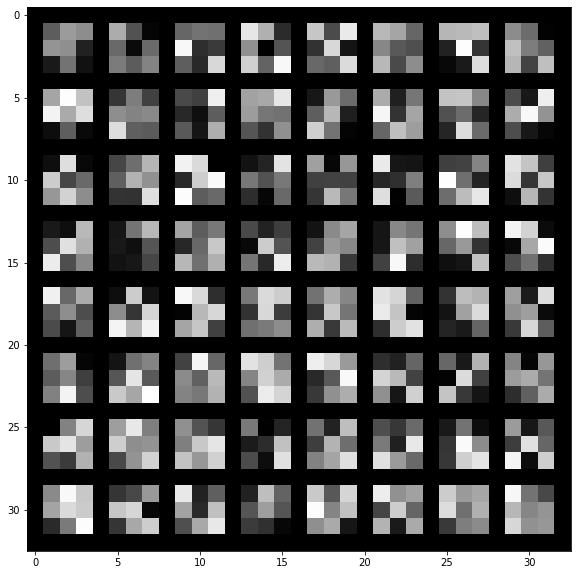

In [ ]:
#레이어 시각화

for w in model_ft.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
plt.imshow(x_grid.permute(2,1,0))

In [ ]:
summary(model_ft.to('cuda'),(1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
         LeakyReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
         LeakyReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
         LeakyReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
         LeakyReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
        LeakyReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
        LeakyReLU-14        [-1, 256, 1

In [ ]:
model_ft = model_ft.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.001)# 업데이트 할 파라미터만 넣어준다.

In [ ]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, train_dict, val_dict  = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------
train Loss: 208819765.0773 Acc: 0.2928, Time : 1438.1241
val Loss: 2.1961 Acc: 0.3084, Time : 153.7583
Epoch 1/4
----------
train Loss: 2.1933 Acc: 0.3083, Time : 1410.2478
val Loss: 2.1915 Acc: 0.3084, Time : 146.3049
Epoch 2/4
----------
train Loss: 2.1924 Acc: 0.3083, Time : 1394.5310
val Loss: 2.1914 Acc: 0.3084, Time : 146.1535
Epoch 3/4
----------
train Loss: 2.1923 Acc: 0.3083, Time : 1395.0476
val Loss: 2.1914 Acc: 0.3084, Time : 146.3354
Epoch 4/4
----------
train Loss: 2.1922 Acc: 0.3083, Time : 1395.4708
val Loss: 2.1918 Acc: 0.3084, Time : 146.1031
Training complete in 129m 32s
Best val Acc: 0.308413


torch.Size([64, 1, 3, 3])


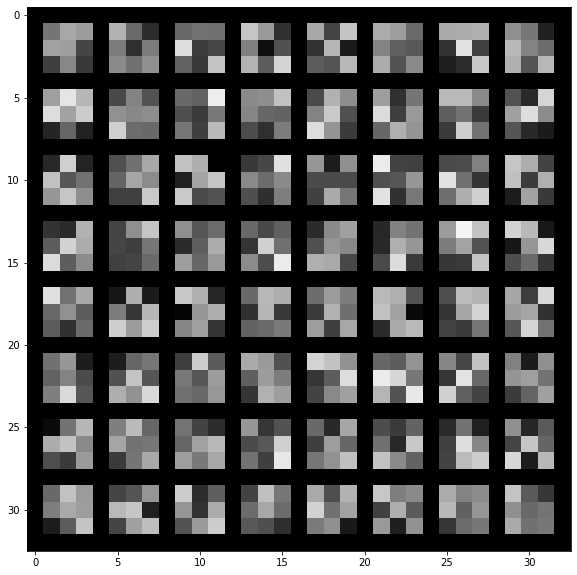

In [ ]:
#레이어 시각화

for w in model_ft.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
plt.imshow(x_grid.permute(2,1,0))

In [ ]:
torch.save(model_ft, '/content/drive/Shareddrives/캡스톤 디자인1/codes/vgg16_multiclassclassfication_model_drop_nofinding.pt')

In [ ]:
train_loss = []
val_loss = []
for i in range(len(train_dict['Loss'])):
  train_loss.append(train_dict['Loss'][i])
for i in range(len(val_dict['Loss'])):
  val_loss.append(val_dict['Loss'][i])

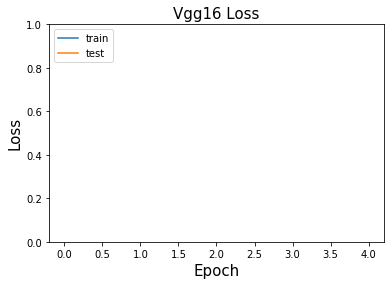

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Vgg16 Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,1)
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
train_accuracy = []
val_accuracy = []
for i in range(len(train_dict['Accuarcy'])):
  train_accuracy.append(train_dict['Accuarcy'][i].to('cpu').numpy())
for i in range(len(val_dict['Accuarcy'])):
  val_accuracy.append(val_dict['Accuarcy'][i].to('cpu').numpy())

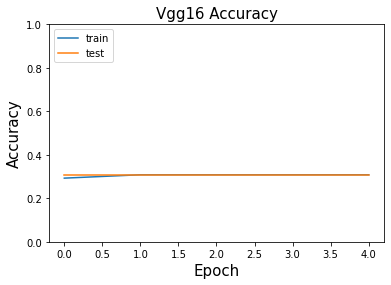

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.title('Vgg16 Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim(0,1)
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
model_ft = torch.load('/content/drive/Shareddrives/캡스톤 디자인1/codes/vgg16_multiclassclassfication_model_drop_nofinding.pt')

In [ ]:
model_ft = model_ft.to(device)


# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(),lr=0.001)# 업데이트 할 파라미터만 넣어준다.
class test_Dataset(Dataset):
    def __init__(self, data_path,transform = None):
        self.data_path = data_path
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        img = np.array(Image.open(path))
        img = img[:,:,np.newaxis]
        img = img/255
        label =  class2idx[df[df['Image Index']== path.split('/')[-1]]['Finding Labels'].values[0]]
        if self.transform is not None:
            transformed = self.transform(image=img)
            image = transformed['image']
        return image.float(), label

In [ ]:
data_transforms_test = A.Compose(
        [
     ToTensorV2()
     ]
     )

In [ ]:
test_data = test_Dataset(val_path,transform = data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle= False)

In [ ]:
running_loss = 0.0
running_corrects = 0
start = time.time()
output_list = list()
criterion = nn.CrossEntropyLoss()

for inputs, labels in test_loader:
    inputs = inputs.to(device = device, dtype = torch.float32)
    labels = labels.to(device = device)
    # zero the parameter gradients
    optimizer_ft.zero_grad()
    outputs = model_ft(inputs)
    output_list+=list((torch.argmax(outputs,axis = 1).cpu().numpy()))
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
print('Test Loss: {:.4f} Acc: {:.4f}, Time : {:.4f}'.format(epoch_loss, epoch_acc, time.time()-start))

Test Loss: 2.1961 Acc: 0.3084, Time : 145.7528


In [ ]:
len(test_loader)*2

6194

In [ ]:
labels

tensor([4], device='cuda:0')

In [ ]:
torch.argmax(outputs,axis = 1).cpu().numpy()

array([8])

In [ ]:
outputs.shape

torch.Size([1, 14])

In [ ]:
dummy_df = pd.DataFrame(output_list)

In [ ]:
dummy_df.value_counts()

8    6193
dtype: int64

In [ ]:
val_df['Finding Labels'].value_counts()

Infiltration          1910
Atelectasis            843
Effusion               791
Nodule                 541
Pneumothorax           439
Mass                   428
Consolidation          262
Pleural_Thickening     225
Cardiomegaly           219
Emphysema              178
Fibrosis               145
Edema                  126
Pneumonia               64
Hernia                  22
Name: Finding Labels, dtype: int64

In [ ]:
class2idx

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'Nodule': 10,
 'Pleural_Thickening': 11,
 'Pneumonia': 12,
 'Pneumothorax': 13}

torch.Size([64, 1, 3, 3])


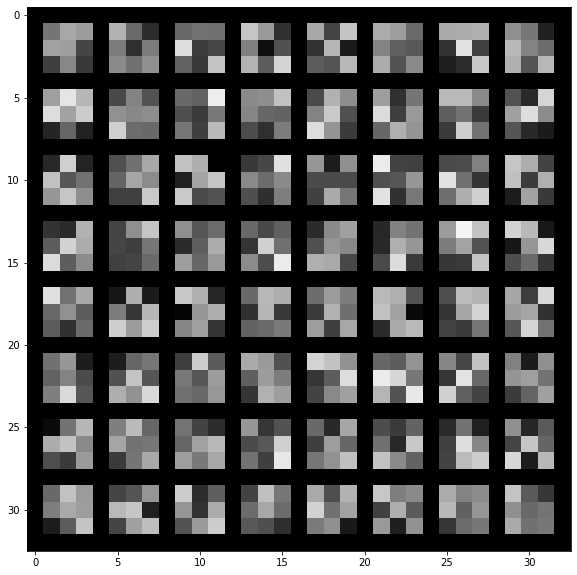

In [ ]:
#레이어 시각화

for w in model_ft.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
plt.imshow(x_grid.permute(2,1,0))

In [ ]:
sample_image = np.array(Image.open(train_path[0]))
sample_image = sample_image[:,:,np.newaxis]/255
transform = transforms.Compose([
    transforms.ToTensor()
])
sample_image = transform(sample_image)
sample_image=sample_image.unsqueeze(0)

In [ ]:
no_of_layers=0
conv_layers=[]

model_children=list(model_ft.children())

for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

13


In [ ]:
results = [conv_layers[0](sample_image.to(device = device, dtype = torch.float32))]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

In [ ]:
# visualize 8 features map from each layer 
for num_layer in range(len(results)):
    plt.figure(figsize=(50, 10))
    layer_viz = results[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print("Layer ",num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        plt.subplot(2, 8, i + 1)
        plt.imshow(filter.cpu().numpy(), cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()